In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import signal as sg
from datetime import datetime as dt

In [8]:
def prcrng(x):
    return (np.nanpercentile(x,84) - np.nanpercentile(x,16))/2.

In [9]:
DIN_acs = "/data/datasets/cruise_data/active/SyncED_Quest/Processed/Step3/"
fn_optics = "quest24_IOP.nc"

In [10]:
# read ACS data
fn_acs = fn_optics
fn_optics
DIN_acs + fn_acs
acs = xr.open_dataset(DIN_acs + fn_acs)
acs.close()

# replace uway_long with uway_lon
if "uway_long" in acs.keys():
    acs.uway_lon = acs.uway_long
    acs = acs.drop(labels="uway_long")

acs

list(acs.keys())

['flow',
 'acs_chl',
 'acs_ap',
 'acs_ap_u',
 'acs_bp',
 'acs_bp_u',
 'acs_cp',
 'acs_cp_u',
 'acs_N',
 'acs2_chl',
 'acs2_ap',
 'acs2_ap_u',
 'acs2_bp',
 'acs2_bp_u',
 'acs2_cp',
 'acs2_cp_u',
 'acs2_N',
 'ac9_chl',
 'ac9_ap',
 'ac9_ap_u',
 'ac9_bp',
 'ac9_bp_u',
 'ac9_cp',
 'ac9_cp_u',
 'ac9_N',
 'bb3_bbp',
 'bb3_bbp_err',
 'bb3_bb02',
 'bb3_bb02_err',
 'bb3_bbp_corr',
 'cstar_cp',
 'cstar_cp_err',
 'ctd_sst',
 'ctd_sal',
 'uway_lat',
 'uway_lon',
 'uway_wind_speed',
 'uway_wind_dir',
 'uway_pressure',
 'uway_humidity',
 'uway_air_temp',
 'uway_dew_temp',
 'uway_chlor',
 'uway_cdom',
 'uway_turb',
 'uway_sst',
 'uway_conductivty',
 'uway_salinity',
 'uway_inlet_temp',
 'uway_trasmittance',
 'uway_oxygen',
 'uway_par']

In [11]:
acs

<xarray.Dataset>
Dimensions:            (time: 1440, acs_wv: 176, ac9_wv: 9, acs2_wv: 176,
                        bb3_wv: 3)
Coordinates:
  * time               (time) datetime64[ns] 2022-06-23 ... 2022-06-23T23:59:...
  * acs_wv             (acs_wv) float64 400.0 402.0 404.0 ... 746.0 748.0 750.0
  * ac9_wv             (ac9_wv) float64 nan nan nan nan nan nan nan nan nan
  * acs2_wv            (acs2_wv) float64 400.0 402.0 404.0 ... 746.0 748.0 750.0
  * bb3_wv             (bb3_wv) float64 470.0 532.0 700.0
Data variables: (12/52)
    flow               (time) float64 ...
    acs_chl            (time) float64 ...
    acs_ap             (time, acs_wv) float64 ...
    acs_ap_u           (time, acs_wv) float64 ...
    acs_bp             (time, acs_wv) float64 ...
    acs_bp_u           (time, acs_wv) float64 ...
    ...                 ...
    uway_conductivty   (time) float64 ...
    uway_salinity      (time) float64 ...
    uway_inlet_temp    (time) float64 ...
    uway_trasmittance  (time) float64 ...
    uway_oxygen        (time) float64 ...
    uway_par           (time) float64 ...

 check this manual step for each cruise


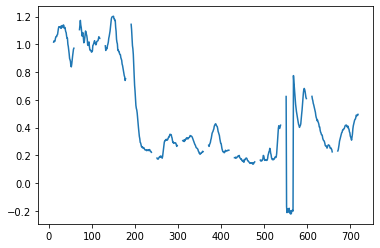

In [12]:
# manually identify (using plot above) noisy parts of the acx_chl timeseries
print(' check this manual step for each cruise')
i2rm = [[5, 10],  # start and end index of noisy period 1 # AMT28
        [15, 20], # start and end index of noisy period 2
       ]

# i2rm = [] # turned off as default
plt.figure()
plt.plot(acs['acs_chl'])

# set values to nan inside the above intervals
if 'acx_chl' in  acs.keys():
    for istart,tmp in enumerate(i2rm):
            acs['acx_chl'].values[tmp[0]:tmp[1]] = np.nan
            acs['acs_ap'].values[tmp[0]:tmp[1], :] = np.nan
            acs['acs_ap_u'].values[tmp[0]:tmp[1], :] = np.nan

else:
    for istart,tmp in enumerate(i2rm):
           acs['acs_chl'].values[tmp[0]:tmp[1]] = np.nan
           acs['acs_ap'].values[tmp[0]:tmp[1], :] = np.nan

[]
[   0    1    2 ... 1437 1438 1439]
[   0    1    2 ... 1437 1438 1439]


(30.0, 38.0)

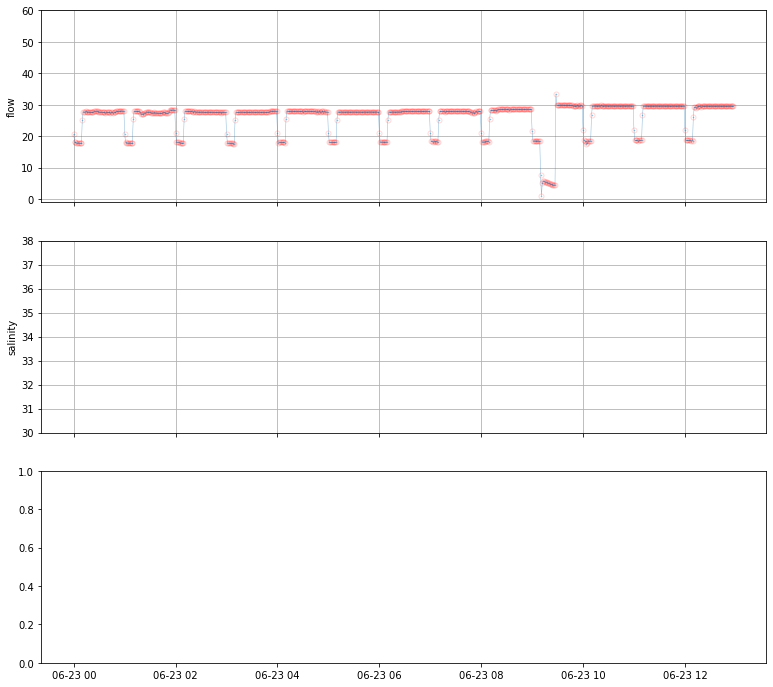

In [16]:
# filter acs data for MQ and noisy events - possibly adjust for quest
MIN_FLOW_RATE = 25
MIN_SAL = 33 

i2f1 = np.where((acs.uway_salinity > MIN_SAL) & (acs.flow > MIN_FLOW_RATE))[0]  
i2f2 = np.where((np.isnan(acs.uway_salinity)==True) | (np.isnan(acs.flow)==True))[0]

i2f = np.union1d(i2f1, i2f2)

print(i2f1)
print(i2f2)
print(i2f)

fig, ax = plt.subplots(3,1, figsize=(13, 12), sharex=True)
ax[0].plot(acs.time, acs.flow, '.-', lw=0.5, ms=1, alpha=0.5)
ax[0].plot(acs.time[i2f], acs.flow[i2f], 'ro', lw=0.5, ms=5, mfc='none', alpha=0.15)
ax[0].set_ylabel('flow')
ax[0].grid('on')
ax[0].set_ylim([-1, 60])


ax[1].plot(acs.time, acs.uway_salinity, '.-', lw=0.5, ms=1, alpha=0.5)
ax[1].plot(acs.time[i2f], acs.uway_salinity[i2f], 'r.', lw=0.1, ms=3, mfc='none', alpha=0.15)
ax[1].set_ylabel('salinity')
ax[1].grid('on')
ax[1].set_ylim([30, 38])



Text(0.5, 0, 'Time (UTC)')

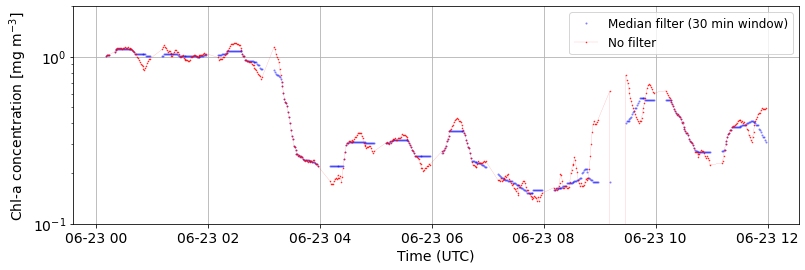

In [36]:
# median filter data
innan = np.where(~np.isnan(acs.acs_chl[i2f]))[0] # need to remove nans to prevent medfilt to be spiky near edges
innan2 = np.where(~np.isnan(acs.acs2_chl[i2f]))[0] # need to remove nans to prevent medfilt to be spiky near edges

fig2, ax2 = plt.subplots(1, figsize=(13, 4))
plt.rcParams.update({'font.size': 12})
MEDFILT_WIN = 31
ax2.semilogy(acs.time[i2f][innan], sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=MEDFILT_WIN), 'bo', lw=1, ms=1, mfc='none', alpha = 0.5, label='Median filter (30 min window)')
MEDFILT_WIN = 1
ax2.semilogy(acs.time[i2f][innan], acs.acs_chl[i2f][innan], 'r.-', lw=0.1, ms=1, mfc='none', label='No filter')
# ax2.semilogy(acs.time[i2f][innan2], acs.acs2_chl[i2f][innan2], 'k.-', lw=0.1, ms=1, mfc='none')
# ax2.semilogy(acs.time[i2f][innan2], sg.medfilt(acs.acs2_chl[i2f][innan2], kernel_size=MEDFILT_WIN), 'bo',color='orange', lw=1, ms=1, mfc='none', alpha = 0.5, label='ACS2: med filt')
ax2.grid('on')
plt.legend()
plt.ylim([1e-1, 2])
plt.ylabel('Chl-a concentration [mg m$^{-3}$]')
plt.xlabel('Time (UTC)')


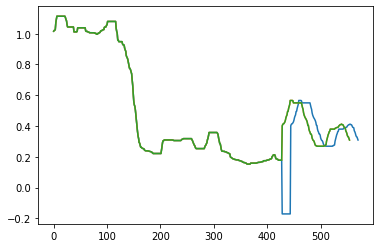

In [18]:
# step x - # filters w.r.t. i2fn (mQ interval + previous manual spike removal) and innan
plt.figure()
ix = xr.DataArray(acs.time[i2f][innan], dims=['time']) 
acs_filtered_x = acs.sel(time = ix)
acs_filtered_x['acs_chl'].values = sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=1)# Filter-size set to 1 as default #
plt.plot(acs_filtered_x['acs_chl'].values)

# step y - # filters w.r.t. ap (10th element) being > 0
i2kp = np.where((acs_filtered_x.acs_ap[:,10] > 0)) [0]
iy = xr.DataArray(acs_filtered_x.time[i2kp], dims=['time']) 
acs_filtered_xy = acs_filtered_x.sel(time = iy)
plt.plot(acs_filtered_xy['acs_chl'].values)

# step z - # filters w.r.t. acs chl being > 0
i2kp = np.where((acs_filtered_xy.acs_chl[:] > 0)) [0]
iz = xr.DataArray(acs_filtered_xy.time[i2kp], dims=['time']) 
acs_filtered_xyz = acs_filtered_xy.sel(time = iz)
plt.plot(acs_filtered_xyz['acs_chl'].values)


In [21]:
# manual clean up of keys
acs_filtered_xyz = acs_filtered_xyz.drop('ac9_N')
acs_filtered_xyz = acs_filtered_xyz.drop('ac9_ap')
acs_filtered_xyz = acs_filtered_xyz.drop('ac9_ap_u')
acs_filtered_xyz = acs_filtered_xyz.drop('ac9_bp')
acs_filtered_xyz = acs_filtered_xyz.drop('ac9_bp_u')
acs_filtered_xyz = acs_filtered_xyz.drop('ac9_chl')
acs_filtered_xyz = acs_filtered_xyz.drop('ac9_cp')
acs_filtered_xyz = acs_filtered_xyz.drop('ac9_cp_u')
acs_filtered_xyz = acs_filtered_xyz.drop('ac9_wv')

acs_filtered_xyz = acs_filtered_xyz.drop('acs2_N')
acs_filtered_xyz = acs_filtered_xyz.drop('acs2_ap')
acs_filtered_xyz = acs_filtered_xyz.drop('acs2_ap_u')
acs_filtered_xyz = acs_filtered_xyz.drop('acs2_bp')
acs_filtered_xyz = acs_filtered_xyz.drop('acs2_bp_u')
acs_filtered_xyz = acs_filtered_xyz.drop('acs2_chl')
acs_filtered_xyz = acs_filtered_xyz.drop('acs2_cp')
acs_filtered_xyz = acs_filtered_xyz.drop('acs2_cp_u')
acs_filtered_xyz = acs_filtered_xyz.drop('acs2_wv')

In [22]:
# save updated NetCDF file
acs_filtered_xyz.to_netcdf(DIN_acs + fn_acs[:-3] + '_QC.nc')
acs_filtered_xyz.close()
